<a href="https://colab.research.google.com/github/RafiShiddik/Dashboard-Segmentasi-Pelanggan-Asuransi/blob/main/Customer_Lifetime_Value_Segmentation_and_Retention_Analysis_using_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


#split training set and test set
from sklearn.model_selection import train_test_split
# import regression model
from sklearn.linear_model import LinearRegression
# import metrics module from scikit-learn
from sklearn import metrics

# load lifetimes plotting module
from lifetimes.plotting import *
# load lifetimes utils module
from lifetimes.utils import *
# load BetaGeoFitter model
from lifetimes import BetaGeoFitter
# load GammaGammaFitter
from lifetimes import GammaGammaFitter

# seaborn for preety data visualization
import seaborn as sns

# import datetime for date manipulation
import datetime as dt

#Load Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/customer_segmentation_data.csv')
df.head()

Customer ID  Age  Gender Marital Status    Education Level  \
0        84966   23  Female        Married   Associate Degree   
1        95568   26    Male        Widowed          Doctorate   
2        10544   29  Female         Single   Associate Degree   
3        77033   20    Male       Divorced  Bachelor's Degree   
4        88160   25  Female      Separated  Bachelor's Degree   

  Geographic Information    Occupation  Income Level Behavioral Data  \
0                Mizoram  Entrepreneur         70541         policy5   
1                    Goa       Manager         54168         policy5   
2              Rajasthan  Entrepreneur         73899         policy5   
3                 Sikkim  Entrepreneur         63381         policy5   
4            West Bengal       Manager         38794         policy1   

  Purchase History Interactions with Customer Service  \
0       04-10-2018                              Phone   
1       11-06-2018                               Chat   
2       06-05-2021                              Email   
3       09-02-2018                               Chat   
4       09-10-2018                               Chat   

  Insurance Products Owned  Coverage Amount  Premium Amount Policy Type  \
0                  policy2           366603            2749       Group   
1                  policy1           780236            1966       Group   
2                  policy3           773926            4413       Group   
3                  policy2           787815            4342      Family   
4                  policy4           366506            1276      Family   

  Customer Preferences Preferred Communication Channel Preferred Contact Time  \
0                Email               In-Person Meeting              Afternoon   
1                 Mail               In-Person Meeting                Morning   
2                Email                            Mail                Evening   
3                 Text               In-Person Meeting                Anytime   
4                Email                            Text               Weekends   

  Preferred Language Segmentation Group  
0            English           Segment5  
1             French           Segment5  
2             German           Segment3  
3             French           Segment3  
4            English           Segment2

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Customer ID                         38765 non-null  int64 
 1   Age                                 38765 non-null  int64 
 2   Gender                              38765 non-null  object
 3   Marital Status                      38765 non-null  object
 4   Education Level                     38765 non-null  object
 5   Geographic Information              38765 non-null  object
 6   Occupation                          38765 non-null  object
 7   Income Level                        38765 non-null  int64 
 8   Behavioral Data                     38765 non-null  object
 9   Purchase History                    38765 non-null  object
 10  Interactions with Customer Service  38765 non-null  object
 11  Insurance Products Owned            38765 non-null  ob

In [5]:
df['Customer ID'].nunique()

31386

In [6]:
df.duplicated().sum()

np.int64(0)

karena ketika melihat nilau nunique ini berjumlah 31386 maka dapat dikatakan bahwa ada penggandaan customer id dengan pembelian yang berbeda

In [7]:
df.isnull().sum()

Customer ID                           0
Age                                   0
Gender                                0
Marital Status                        0
Education Level                       0
Geographic Information                0
Occupation                            0
Income Level                          0
Behavioral Data                       0
Purchase History                      0
Interactions with Customer Service    0
Insurance Products Owned              0
Coverage Amount                       0
Premium Amount                        0
Policy Type                           1
Customer Preferences                  1
Preferred Communication Channel       1
Preferred Contact Time                1
Preferred Language                    1
Segmentation Group                    1
dtype: int64

In [8]:
#ini tidak bisa dlakukan akrena dalam kolom purchase ada beragam ada yang berisi d-m-Y ada juga yang isinya d/m/Y
#karena pandas sudah bisa melakukan mixed maka bisa dilakukan dengan cara di mixed tidak usah pilih satu satu menggunakan - atau / sebagai pemisah
#df['Purchase History'] = pd.to_datetime(df['Purchase History'], format='%d-%m-%Y')

In [9]:
df['Purchase History'] = pd.to_datetime(df['Purchase History'], format='mixed', dayfirst=True, errors='coerce')

In [10]:
snapshot_date = df['Purchase History'].max() + pd.Timedelta(days=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Customer ID                         38765 non-null  int64         
 1   Age                                 38765 non-null  int64         
 2   Gender                              38765 non-null  object        
 3   Marital Status                      38765 non-null  object        
 4   Education Level                     38765 non-null  object        
 5   Geographic Information              38765 non-null  object        
 6   Occupation                          38765 non-null  object        
 7   Income Level                        38765 non-null  int64         
 8   Behavioral Data                     38765 non-null  object        
 9   Purchase History                    38765 non-null  datetime64[ns]
 10  Interactions with Cust

In [12]:
df['Education Level'].unique()

array(['Associate Degree', 'Doctorate', "Bachelor's Degree",
       "Master's Degree", 'High School Diploma'], dtype=object)

In [13]:
# Anggap churn jika tidak beli selama 6 bulan terakhir
df['churned'] = df['Purchase History'] < snapshot_date - pd.Timedelta(days=180)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Customer ID                         38765 non-null  int64         
 1   Age                                 38765 non-null  int64         
 2   Gender                              38765 non-null  object        
 3   Marital Status                      38765 non-null  object        
 4   Education Level                     38765 non-null  object        
 5   Geographic Information              38765 non-null  object        
 6   Occupation                          38765 non-null  object        
 7   Income Level                        38765 non-null  int64         
 8   Behavioral Data                     38765 non-null  object        
 9   Purchase History                    38765 non-null  datetime64[ns]
 10  Interactions with Cust

#Eksplorasi Data

In [15]:
df["Purchase History"] = pd.to_datetime(df['Purchase History'], infer_datetime_format=True)

In [16]:
top_10_languages = (
    df.groupby('Geographic Information', as_index=False)
      .agg({'Customer ID': 'nunique'})
      .sort_values(by='Customer ID', ascending=False)
      .head(15)
)

top_10_languages.reset_index(drop=True, inplace=True)

top_10_languages

Geographic Information  Customer ID
0                   Lakshadweep         1538
1              Himachal Pradesh         1443
2                         Bihar         1417
3             Arunachal Pradesh         1416
4                       Haryana         1360
5                       Gujarat         1349
6                 Uttar Pradesh         1333
7                         Delhi         1277
8                   Uttarakhand         1252
9                Madhya Pradesh         1237
10  Andaman and Nicobar Islands         1193
11                       Sikkim         1176
12                          Goa         1175
13                     Nagaland         1134
14                    Jharkhand         1126

In [17]:
df.describe()

Customer ID           Age   Income Level  \
count   38765.000000  38765.000000   38765.000000   
mean    52199.119567     44.162724   82913.828067   
min         1.000000     18.000000   20001.000000   
25%     28770.000000     32.000000   51571.000000   
50%     55710.000000     43.000000   80990.000000   
75%     76151.000000     57.000000  116130.000000   
max    100000.000000     70.000000  149999.000000   
std     28224.153109     15.080828   36667.843663   

                    Purchase History  Coverage Amount  Premium Amount  
count                          38765     38765.000000    38765.000000  
mean   2021-01-01 01:46:05.494647296    492160.574539     3024.663975  
min              2018-01-01 00:00:00     50001.000000      500.000000  
25%              2019-07-08 00:00:00    247603.000000     1818.000000  
50%              2020-12-28 00:00:00    475419.000000     3193.000000  
75%              2022-07-01 00:00:00    739556.000000     4317.000000  
max              2023-12-28 00:00:00   1000000.000000     5000.000000  
std                              NaN    268807.139101     1286.059869

In [18]:
df['Behavioral Data'].value_counts().head(10)

Behavioral Data
policy3    11458
policy1     7789
policy2     7765
policy5     6827
policy4     4926
Name: count, dtype: int64

In [19]:
df.groupby('Behavioral Data')['churned'].mean().sort_values(ascending=False)

Behavioral Data
policy2    0.922473
policy5    0.918559
policy4    0.918189
policy3    0.917787
policy1    0.914366
Name: churned, dtype: float64

karena column ini tidak ada column quantity maka untuk pengembalian barang bisa aku abaikan untuk sementara waktu.

In [20]:
from lifetimes.utils import summary_data_from_transaction_data

# Step 1: Siapkan Data
df_cltv = df[['Customer ID', 'Purchase History', 'Premium Amount']].copy()
df_cltv.columns = ['customer_id', 'purchase_date', 'amount']  # rename biar standar

# Step 2: Pastikan tanggal sudah format datetime
df_cltv['purchase_date'] = pd.to_datetime(df_cltv['purchase_date'], errors='coerce')

# Step 3: Hitung snapshot date
snapshot_date = df_cltv['purchase_date'].max() + pd.Timedelta(days=1)

# Step 4: Gunakan fungsi lifetimes untuk summary
summary = summary_data_from_transaction_data(
    df_cltv,
    customer_id_col='customer_id',
    datetime_col='purchase_date',
    monetary_value_col='amount',
    observation_period_end=snapshot_date
)

summary.head()


frequency  recency       T  monetary_value
customer_id                                            
1                 24.0   2134.0  2165.0     3626.291667
5                  0.0      0.0   680.0        0.000000
23                 0.0      0.0   339.0        0.000000
37                 0.0      0.0   297.0        0.000000
49                 0.0      0.0  1203.0        0.000000

#Headling outliner

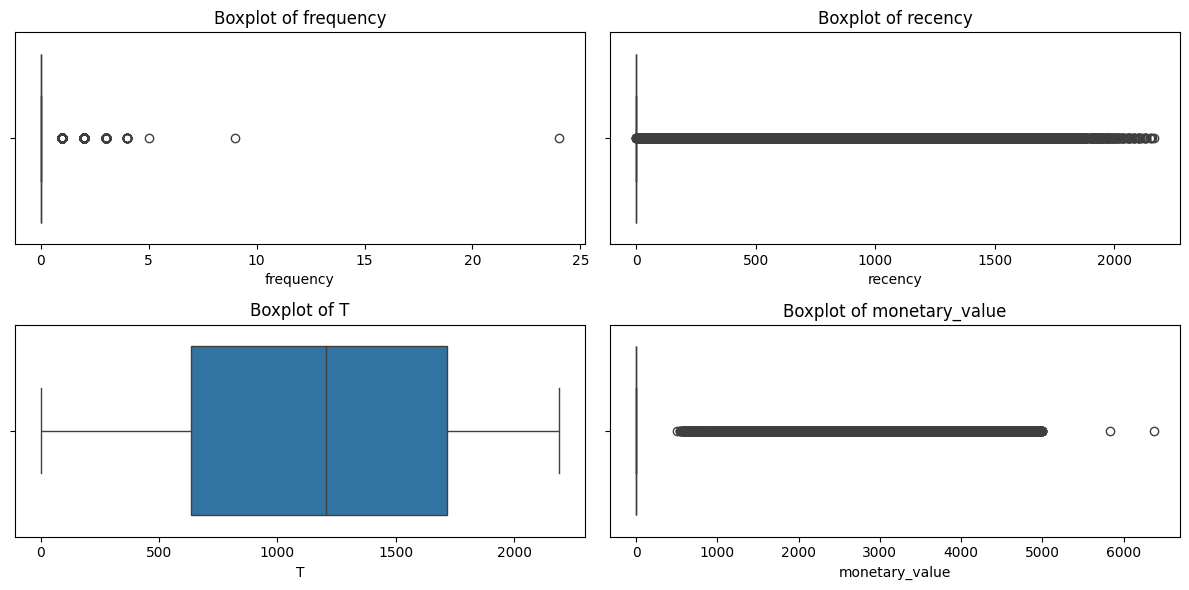

In [21]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(['frequency', 'recency', 'T', 'monetary_value']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=summary, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [22]:

# Copy summary agar tidak ubah aslinya
summary_clean = summary.copy()

# Cap frequency di 95 percentile
freq_cap = np.percentile(summary_clean['frequency'], 95)
summary_clean['frequency'] = np.where(summary_clean['frequency'] > freq_cap,
                                      freq_cap,
                                      summary_clean['frequency'])

# Winsorize monetary_value (1% - 99%)
low, high = np.percentile(summary_clean['monetary_value'], [1, 99])
summary_clean['monetary_value'] = summary_clean['monetary_value'].clip(low, high)

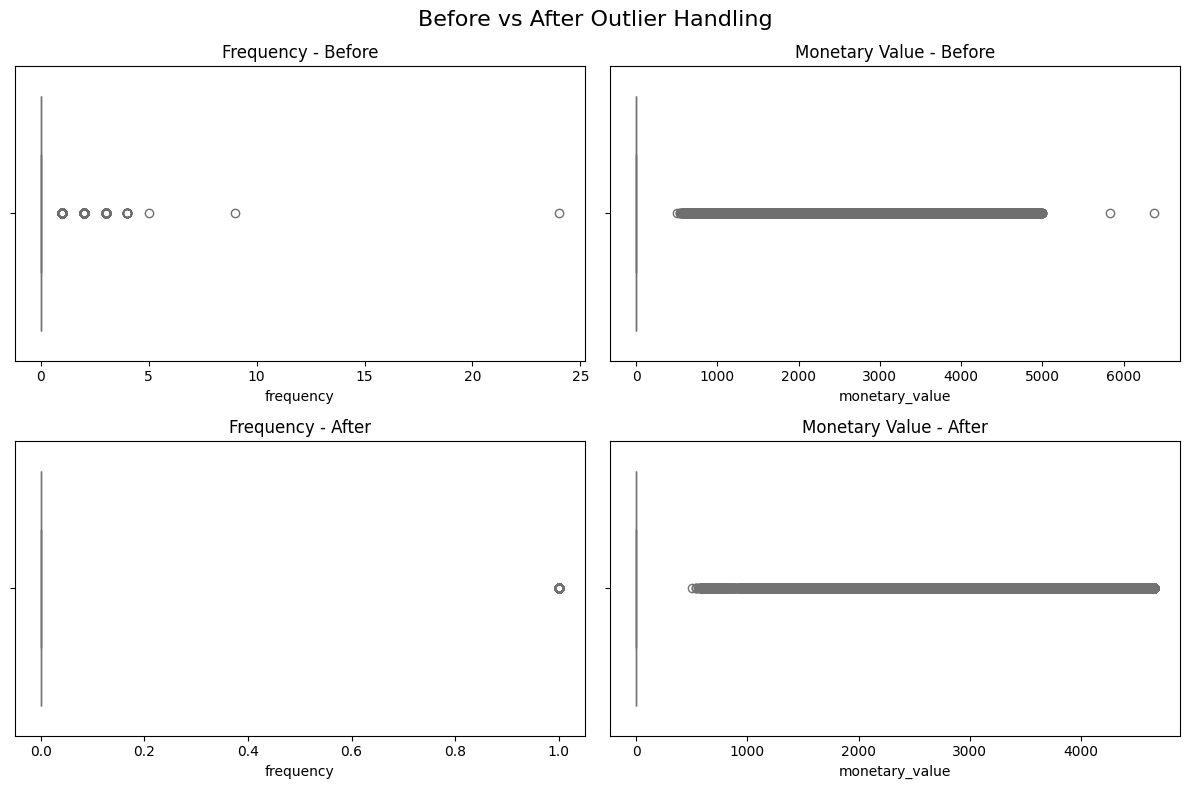

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Before vs After Outlier Handling", fontsize=16)

# Frequency
sns.boxplot(x=summary['frequency'], ax=axes[0,0], color='skyblue')
axes[0,0].set_title("Frequency - Before")
sns.boxplot(x=summary_clean['frequency'], ax=axes[1,0], color='lightgreen')
axes[1,0].set_title("Frequency - After")

# Monetary Value
sns.boxplot(x=summary['monetary_value'], ax=axes[0,1], color='skyblue')
axes[0,1].set_title("Monetary Value - Before")
sns.boxplot(x=summary_clean['monetary_value'], ax=axes[1,1], color='lightgreen')
axes[1,1].set_title("Monetary Value - After")

plt.tight_layout()
plt.show()


#Calculate Purchase Frequency, Calculate Repeat Rate and Churn Rate

In [24]:
# Hitung jumlah total transaksi
total_orders = df.shape[0]

# Hitung jumlah pelanggan unik
total_customers = df['Customer ID'].nunique()

# Hitung purchase frequency
purchase_frequency = total_orders / total_customers
print("Purchase Frequency:", purchase_frequency)

Purchase Frequency: 1.2351048238067928


In [25]:
# Hitung jumlah transaksi per customer
customer_order_counts = df.groupby('Customer ID').size()

# Hitung repeat customers (lebih dari 1 transaksi)
repeat_customers = customer_order_counts[customer_order_counts > 1].count()

# Hitung repeat rate
repeat_rate = repeat_customers / total_customers
print("Repeat Rate:", repeat_rate)


Repeat Rate: 0.19954756897979992


In [26]:
churn_rate = 1 - repeat_rate
print("Churn Rate:", churn_rate)

Churn Rate: 0.8004524310202001


Angka churn rate yang tinggi (80%) menunjukkan bahwa banyak pelanggan hanya belanja sekali.

Fokus untuk meningkatkan repeat rate (misalnya dengan loyalty program, retargeting, atau layanan pelanggan) dapat meningkatkan CLTV (Customer Lifetime Value) secara signifikan.

In [27]:
cltv_ready = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)]

Text(0.5, 1.0, 'Frequency')

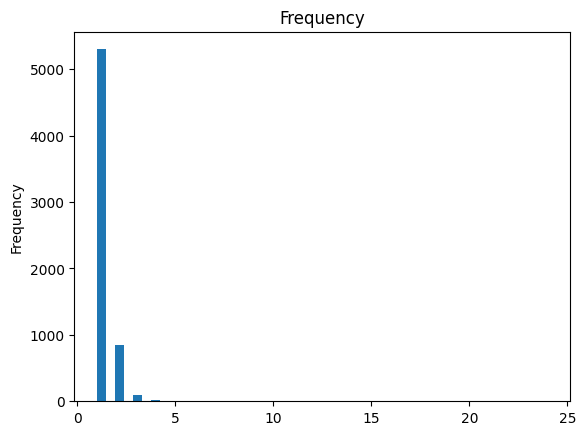

In [28]:
cltv_ready['frequency'].plot(kind='hist', bins=50)
plt.title('Frequency')

In [29]:
print(cltv_ready['frequency'].describe())

count    6257.000000
mean        1.177401
std         0.531171
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        24.000000
Name: frequency, dtype: float64


In [30]:
print(sum(cltv_ready['frequency'] == 0)*100/float(len(df)))

0.0


Rata-rata pelanggan hanya belanja 1 kali.

Ini berkontribusi terhadap tingginya churn rate yang kamu hitung sebelumnya.

Untuk strategi bisnis, kamu bisa mempertimbangkan:
📌 Program loyalitas
📌 Email retargeting
📌 Diskon pembelian kedua
Untuk meningkatkan repeat rate dan menurunkan churn rate, yang nantinya akan menaikkan CLTV.

Text(0.5, 1.0, 'Recency')

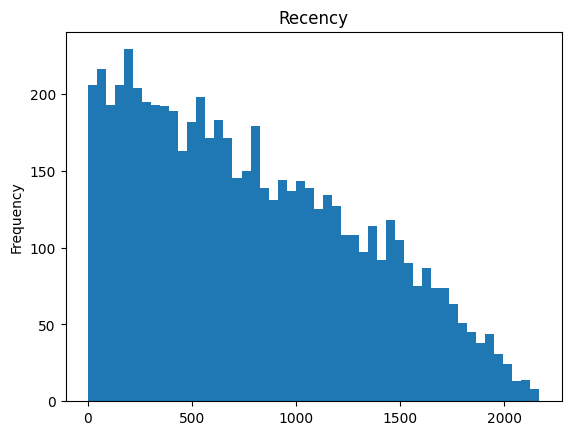

In [31]:
cltv_ready['recency'].plot(kind='hist', bins=50)
plt.title('Recency')

In [32]:
print(cltv_ready['recency'].describe())

count    6257.000000
mean      786.712003
std       532.379488
min         1.000000
25%       330.000000
50%       706.000000
75%      1183.000000
max      2167.000000
Name: recency, dtype: float64


In [33]:
print(sum(cltv_ready['recency'] == 0) * 100/float(len(df)))

0.0


Sebagian besar pelanggan belanja belum terlalu lama, meskipun ada juga yang sudah sangat lama tidak belanja.

Informasi ini penting untuk segmentasi pelanggan:

Recency rendah → aktif / potensial loyal

Recency tinggi → risiko churn

In [34]:
cltv_ready = cltv_ready.query('frequency > 0')

 2. Masalah Utama: Variasi Recency dan T Sangat Besar
Standard deviation recency dan T besar sekali → bisa menyebabkan model tidak stabil saat fitting karena perbedaan skala yang ekstrem.

T harus selalu lebih besar dari recency (✅ sudah benar, karena min T = 7, min recency = 1)

In [35]:
cltv_ready[['frequency', 'recency', 'T']].describe()

frequency      recency            T
count  6257.000000  6257.000000  6257.000000
mean      1.177401   786.712003  1485.016941
std       0.531171   532.379488   513.273060
min       1.000000     1.000000     7.000000
25%       1.000000   330.000000  1143.000000
50%       1.000000   706.000000  1573.000000
75%       1.000000  1183.000000  1913.000000
max      24.000000  2167.000000  2188.000000

In [36]:
# Recency harus >=0, T >= recency, frequency >=0
print((cltv_ready['recency'] < 0).sum(), (cltv_ready['T'] < 0).sum())
print((cltv_ready['recency'] > cltv_ready['T']).sum())

# Lihat distribusi ekstrem
print(cltv_ready[['frequency', 'recency', 'T']].describe())

0 0
0
         frequency      recency            T
count  6257.000000  6257.000000  6257.000000
mean      1.177401   786.712003  1485.016941
std       0.531171   532.379488   513.273060
min       1.000000     1.000000     7.000000
25%       1.000000   330.000000  1143.000000
50%       1.000000   706.000000  1573.000000
75%       1.000000  1183.000000  1913.000000
max      24.000000  2167.000000  2188.000000


In [37]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(cltv_ready['frequency'], cltv_ready['recency'], cltv_ready['T'])

<lifetimes.BetaGeoFitter: fitted with 6257 subjects, a: 0.87, alpha: 1447.74, b: 0.30, r: 2.32>

In [38]:
summary.head()

frequency  recency       T  monetary_value
customer_id                                            
1                 24.0   2134.0  2165.0     3626.291667
5                  0.0      0.0   680.0        0.000000
23                 0.0      0.0   339.0        0.000000
37                 0.0      0.0   297.0        0.000000
49                 0.0      0.0  1203.0        0.000000

In [39]:
bgf.summary

coef   se(coef)  lower 95% bound  upper 95% bound
r         2.315386   0.050089         2.217212         2.413561
alpha  1447.744397  41.218630      1366.955883      1528.532912
a         0.868989   0.053943         0.763261         0.974717
b         0.302975   0.021226         0.261372         0.344579

#Visualizing our frequency/recency matrix

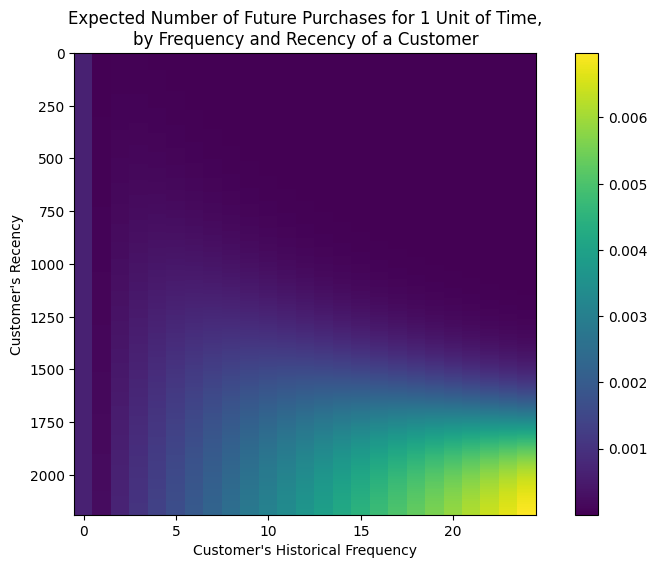

In [40]:
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)
plt.show()

In [41]:
cltv_ready['is_dormant'] = (cltv_ready['recency'] / cltv_ready['T']) > 0.8
cltv_ready['is_dormant'] = cltv_ready['recency'] > 1000


In [42]:
def segment_customer(row):
    if row['frequency'] == 0:
        return 'New'
    elif row['is_dormant']:
        return 'Dormant'
    elif row['recency'] < 200:
        return 'Active'
    else:
        return 'Regular'

cltv_ready['segment'] = cltv_ready.apply(segment_customer, axis=1)


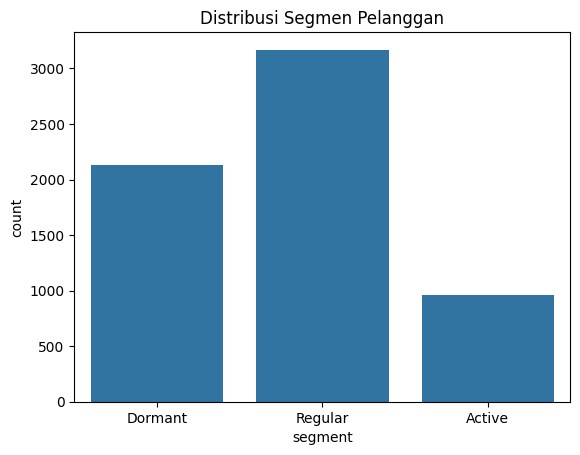

In [43]:
sns.countplot(data=cltv_ready, x='segment')
plt.title("Distribusi Segmen Pelanggan")
plt.show()

Bagian kanan bawah (kuning-hijau):

Pelanggan dengan frekuensi tinggi (10–24 pembelian) dan recency tinggi (artinya mereka belanja belakangan ini).

Pelanggan ini aktif dan sangat mungkin melakukan pembelian lagi.

Target utama untuk kampanye loyalitas 💰

Bagian kiri atas (ungu gelap):

Pelanggan hanya belanja 1–2 kali, dan sudah lama tidak belanja lagi.

Peluang untuk beli lagi sangat rendah → mungkin sudah churn.

Bisa jadi tidak efisien untuk ditargetkan ulang ❌



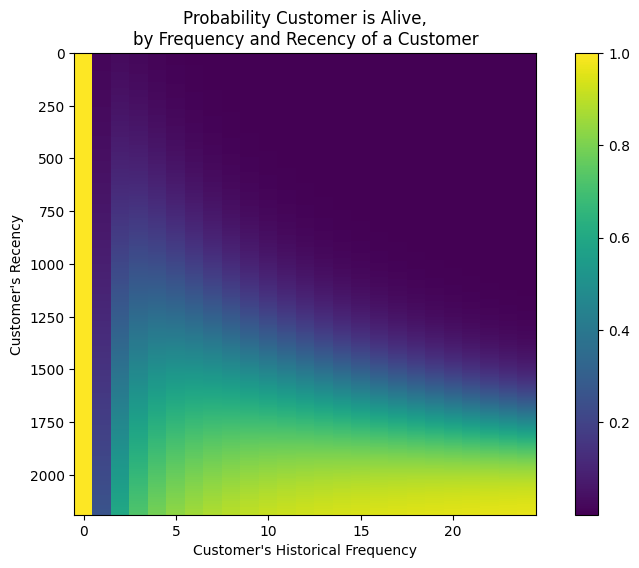

In [44]:
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)
plt.show()

In [45]:
summary['probability_alive'] = bgf.conditional_probability_alive(
    summary['frequency'],
    summary['recency'],
    summary['T']
)

In [46]:
def segment_customer(row):
    # Pelanggan yang sudah sangat lama tidak membeli dan kemungkinan hidupnya sangat kecil
    if row['probability_alive'] < 0.1 and row['recency'] > 1000:
        return 'Dormant'

    # Pelanggan dengan frekuensi >= 2, sudah lama tidak beli, kemungkinan hidup rendah
    elif row['frequency'] >= 2 and row['recency'] > 800 and row['probability_alive'] < 0.2:
        return 'Win Back'

    # Pelanggan aktif dulu, sekarang belum belanja lagi, tapi masih mungkin kembali
    elif row['frequency'] >= 2 and row['recency'] > 500 and row['probability_alive'] >= 0.2 and row['probability_alive'] < 0.5:
        return 'At Risk'

    # Pelanggan aktif, masih membeli dan kemungkinan hidup tinggi
    elif row['frequency'] >= 2 and row['probability_alive'] >= 0.5:
        return 'Active'

    else:
        return 'Others'


In [47]:
summary['segment'] = summary.apply(segment_customer, axis=1)
summary['segment'].value_counts()

segment
Others      30544
At Risk       446
Active        356
Dormant        34
Win Back        6
Name: count, dtype: int64

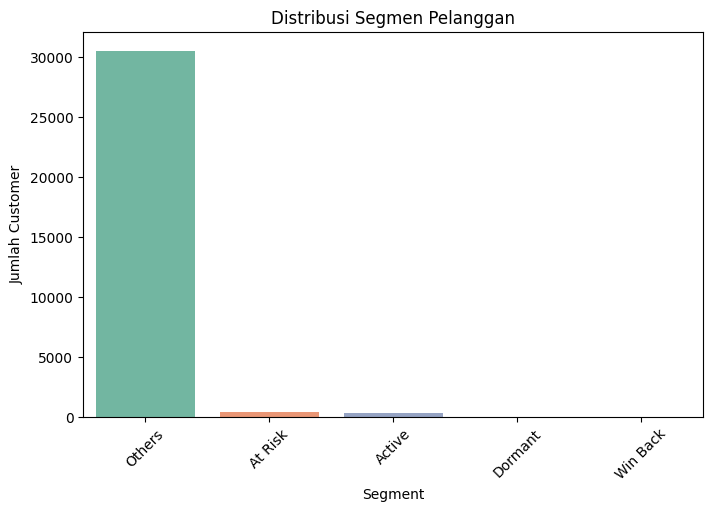

In [48]:
plt.figure(figsize=(8,5))
sns.countplot(x='segment', data=summary, order=summary['segment'].value_counts().index, palette='Set2')
plt.title('Distribusi Segmen Pelanggan')
plt.ylabel('Jumlah Customer')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.show()

In [49]:
summary[['recency', 'frequency', 'T', 'probability_alive']].describe()

recency     frequency             T  probability_alive
count  31386.000000  31386.000000  31386.000000       31386.000000
mean     156.836073      0.234722   1169.519276           0.835837
std      394.063897      0.526797    628.578667           0.334450
min        0.000000      0.000000      1.000000           0.016552
25%        0.000000      0.000000    637.000000           1.000000
50%        0.000000      0.000000   1206.000000           1.000000
75%        0.000000      0.000000   1716.000000           1.000000
max     2167.000000     24.000000   2188.000000           1.000000

In [50]:
min_date = df['Purchase History'].min()
max_date = df['Purchase History'].max()

print("Tanggal pembelian pertama:", min_date)
print("Tanggal pembelian terakhir:", max_date)

Tanggal pembelian pertama: 2018-01-01 00:00:00
Tanggal pembelian terakhir: 2023-12-28 00:00:00


In [51]:
# Urutkan data per pelanggan dan waktu
df_sorted = df.sort_values(by=['Customer ID', 'Purchase History'])

# Hitung selisih antar pembelian
df_sorted['time_diff'] = df_sorted.groupby('Customer ID')['Purchase History'].diff()

# Ambil hanya pelanggan yang punya lebih dari 1 transaksi
multiple_purchases = df_sorted[df_sorted['time_diff'].notna()]

# Hitung rata-rata jeda waktu per pelanggan
avg_time_diff = multiple_purchases.groupby('Customer ID')['time_diff'].mean().reset_index()

# Ubah ke hari
avg_time_diff['avg_days_between_purchases'] = avg_time_diff['time_diff'].dt.days

# Hanya tampilkan kolom yang penting
avg_time_diff = avg_time_diff[['Customer ID', 'avg_days_between_purchases']]

# Tampilkan hasil
print(avg_time_diff.sort_values(by='avg_days_between_purchases').head())

      Customer ID  avg_days_between_purchases
761         13497                           0
3670        67089                           0
2167        38824                           0
3138        63095                           0
86           2678                           0


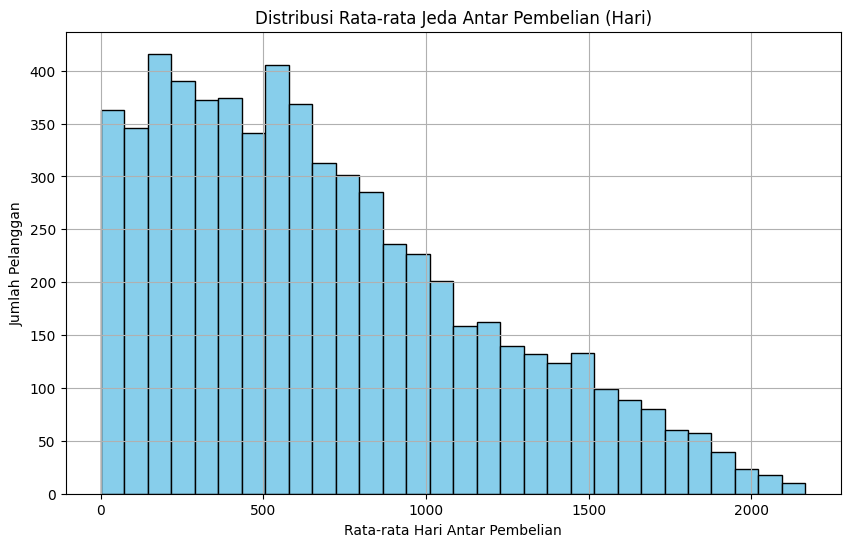

In [52]:
plt.figure(figsize=(10,6))
plt.hist(avg_time_diff['avg_days_between_purchases'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Rata-rata Jeda Antar Pembelian (Hari)')
plt.xlabel('Rata-rata Hari Antar Pembelian')
plt.ylabel('Jumlah Pelanggan')
plt.grid(True)
plt.show()

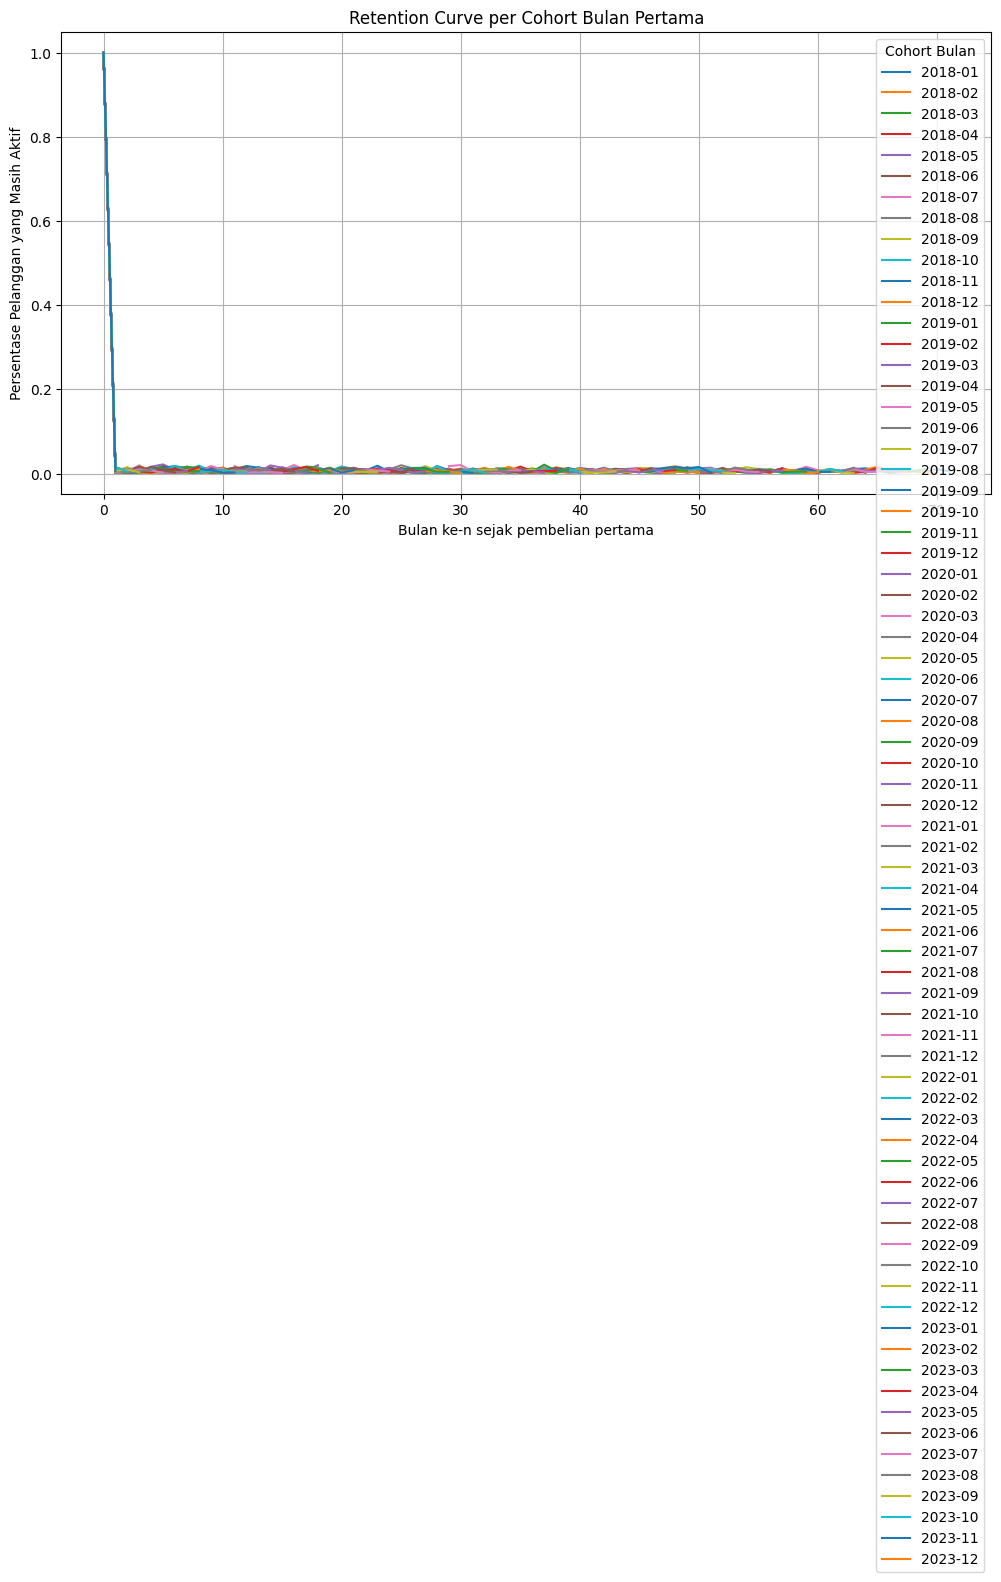

In [53]:
from operator import attrgetter

# 1. Tambahkan kolom bulan pembelian
df['order_month'] = df['Purchase History'].dt.to_period('M')

# 2. Ambil bulan pembelian pertama tiap customer
df['cohort_month'] = df.groupby('Customer ID')['Purchase History'].transform('min').dt.to_period('M')

# 3. Hitung bulan ke-n sejak pembelian pertama
df['cohort_index'] = (df['order_month'] - df['cohort_month']).apply(attrgetter('n'))

# 4. Buat pivot table untuk jumlah pelanggan unik tiap cohort index
cohort_data = df.groupby(['cohort_month', 'cohort_index'])['Customer ID'].nunique().unstack(0)

# 5. Normalisasi terhadap bulan pertama
cohort_size = cohort_data.iloc[0]
retention = cohort_data.divide(cohort_size, axis=1)

# 6. Plot Retention Curve
plt.figure(figsize=(12, 6))
for cohort in retention.columns:
    plt.plot(retention.index, retention[cohort], label=str(cohort))

plt.title('Retention Curve per Cohort Bulan Pertama')
plt.xlabel('Bulan ke-n sejak pembelian pertama')
plt.ylabel('Persentase Pelanggan yang Masih Aktif')
plt.legend(title='Cohort Bulan')
plt.grid(True)
plt.show()

Sebagian besar pelanggan ada di wilayah warna ungu tua di kiri atas → frekuensi rendah dan recency tinggi, alias pelanggan jarang beli dan sudah lama tidak beli.

Beberapa pelanggan ada di kanan bawah dengan warna kuning-hijau → ini adalah pelanggan loyal.

📌 Rekomendasi Tindakan:
Pertahankan pelanggan di kanan bawah (warna cerah)

Berikan program loyalitas, diskon khusus, atau personalisasi.

Reaktivasi pelanggan di kiri bawah

Mereka pernah aktif tapi sekarang tidak. Kirim campaign “kami rindu kamu”.

Tinggalkan pelanggan di kiri atas

Peluangnya sangat kecil untuk kembali, lebih baik alokasikan budget ke segmen lain.

In [54]:
# pick period
t = 30
# predict purchases
cltv_ready['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, cltv_ready['frequency'], cltv_ready['recency'], cltv_ready['T']
)

In [55]:
cltv_ready['prob_alive'] = bgf.conditional_probability_alive(
    cltv_ready['frequency'], cltv_ready['recency'], cltv_ready['T']
)

In [56]:
cltv_ready.sort_values(by='predicted_purchases', ascending = False).head(10)

frequency  recency       T  monetary_value  is_dormant  segment  \
customer_id                                                                    
1                 24.0   2134.0  2165.0     3626.291667        True  Dormant   
100000             9.0   1734.0  1843.0     3154.444444        True  Dormant   
66522              4.0   1694.0  1731.0     2959.250000        True  Dormant   
12937              3.0    914.0   963.0     2279.333333       False  Regular   
87793              5.0    832.0  1282.0     3414.800000       False  Regular   
66948              3.0    873.0   950.0     2695.000000       False  Regular   
62716              4.0   1697.0  1783.0     2611.750000        True  Dormant   
68541              2.0    190.0   268.0     1385.500000       False   Active   
37770              4.0   2127.0  2166.0     3118.000000        True  Dormant   
13360              4.0   2025.0  2157.0     2362.500000        True  Dormant   

             predicted_purchases  prob_alive  
customer_id                                   
1                       0.207942    0.955307  
100000                  0.089025    0.867138  
66522                   0.046178    0.779251  
12937                   0.046177    0.703803  
87793                   0.045535    0.570013  
66948                   0.045529    0.690216  
62716                   0.044446    0.762215  
68541                   0.041047    0.550896  
37770                   0.040696    0.780181  
13360                   0.039229    0.750194

In [57]:
cltv_ready.query('prob_alive >= 0.5 and prob_alive <= 0.7 and monetary_value > 100')

frequency  recency       T  monetary_value  is_dormant  segment  \
customer_id                                                                    
1933               2.0   1255.0  1510.0     4540.000000        True  Dormant   
2036               2.0   1551.0  1603.0     3249.500000        True  Dormant   
2628               3.0   1994.0  2156.0     2758.666667        True  Dormant   
2654               3.0   1709.0  1881.0     4401.000000        True  Dormant   
2704               2.0   1454.0  1567.0     2479.000000        True  Dormant   
2730               2.0   1036.0  1239.0      674.500000        True  Dormant   
2767               2.0   1921.0  1976.0     4624.000000        True  Dormant   
2822               2.0   2039.0  2108.0     4197.000000        True  Dormant   
3055               2.0   1222.0  1356.0     2443.000000        True  Dormant   
3138               2.0   1735.0  1975.0     2993.000000        True  Dormant   
3292               2.0   1651.0  1935.0     1995.000000        True  Dormant   
3434               3.0   1749.0  2120.0     3335.000000        True  Dormant   
3460               2.0   2037.0  2064.0     3930.000000        True  Dormant   
3703               2.0   1952.0  2032.0     1713.000000        True  Dormant   
3785               3.0   1277.0  1807.0     4085.333333        True  Dormant   
4156               2.0    945.0   993.0     4017.000000       False  Regular   
4213               2.0   1429.0  1432.0     3474.000000        True  Dormant   
4444               2.0   1913.0  2010.0     3096.500000        True  Dormant   
4793               3.0   1129.0  1499.0     3985.000000        True  Dormant   
4845               2.0   1716.0  1911.0     3235.500000        True  Dormant   
5180               2.0   1702.0  1818.0     3901.000000        True  Dormant   
5389               2.0    540.0   667.0     1537.500000       False  Regular   
5875               3.0   1606.0  1852.0     3063.333333        True  Dormant   
6168               2.0   1967.0  2076.0     2689.500000        True  Dormant   
9115               2.0   1498.0  1784.0     2947.500000        True  Dormant   
10174              2.0   1375.0  1621.0     2325.000000        True  Dormant   
10187              2.0   1521.0  1686.0     2951.500000        True  Dormant   
10188              2.0   1138.0  1253.0     3331.000000        True  Dormant   
10412              3.0   1866.0  2026.0     1495.000000        True  Dormant   
10579              2.0   1958.0  2062.0     2070.000000        True  Dormant   
10597              2.0   1769.0  1999.0     4233.500000        True  Dormant   
10954              2.0   1291.0  1448.0     2327.000000        True  Dormant   
11640              2.0   1621.0  1658.0     3541.000000        True  Dormant   
11842              2.0   2082.0  2084.0     3270.500000        True  Dormant   
12592              2.0   1857.0  2064.0     1842.000000        True  Dormant   
12666              2.0   1669.0  1815.0     3624.000000        True  Dormant   
12783              4.0   1669.0  2161.0     2302.750000        True  Dormant   
12823              2.0   1675.0  1830.0     2986.500000        True  Dormant   
13198              2.0   1994.0  2124.0     2704.500000        True  Dormant   
13492              2.0   1758.0  1973.0     2810.000000        True  Dormant   
13861              2.0   1714.0  1915.0     3871.500000        True  Dormant   
13906              2.0    569.0   597.0     1516.500000       False  Regular   
14249              2.0    764.0   902.0     2433.500000       False  Regular   
14450              2.0   1758.0  1866.0     4180.500000        True  Dormant   
14492              2.0   1620.0  1812.0     4511.500000        True  Dormant   
14956              2.0   1416.0  1423.0     1943.500000        True  Dormant   
15712              2.0   1251.0  1486.0     1776.000000        True  Dormant   
21593              2.0   1741.0  1878.0     3059.500000        True  Dormant   
22214        

Ini adalah pelanggan yang:

Masih cukup mungkin untuk aktif (prob_alive antara 0.5 dan 0.7)

Memiliki nilai transaksi tinggi (monetary_value > 100)

🎯 Segmen ini cocok untuk:

📩 Target reaktivasi → mereka tidak super loyal, tapi masih punya peluang untuk aktif dan memiliki nilai transaksi yang layak.

📣 Kampanye promo khusus / diskon personalisasi

🧠 Contoh:

customer_id = 2628 masih punya probabilitas 0.51 untuk tetap aktif dan monetary tinggi (2758.67)

customer_id = 2654 punya nilai transaksi luar biasa (4401.00) tapi prob_alive cuma 0.51 → berisiko churn, tapi sangat bernilai!

🚀 Kesimpulan dan Rekomendasi:
Segmen	Strategi
Top predicted_purchases	Pertahankan → loyalty reward, diskon eksklusif
prob_alive 0.5–0.7 & high monetary	Reaktivasi → email marketing, promo comeback, upsell
prob_alive < 0.3	Peluang kecil → alokasi promosi rendah
monetary_value rendah	Tidak prioritas saat ini

#Assessing model fit

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

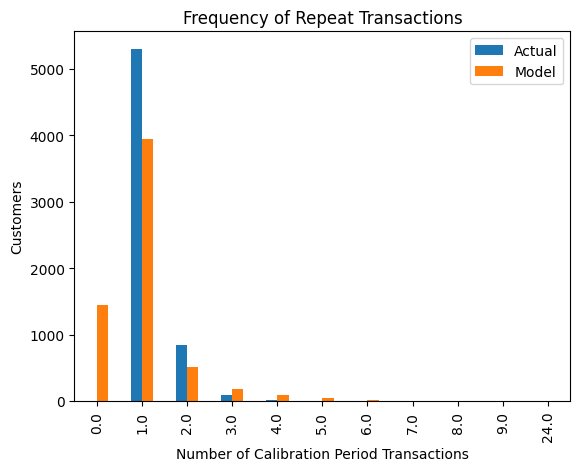

In [58]:
plot_period_transactions(bgf, max_frequency=10)

Model cukup baik:

Prediksi model tidak jauh meleset dari data aktual, terutama untuk frekuensi rendah (1–2 transaksi).

Ini menunjukkan model cukup mampu merepresentasikan pola frekuensi transaksi pelangganmu.

Gap kecil di frekuensi tinggi:

Untuk pelanggan yang melakukan 3+ transaksi, model sedikit underpredict.

Ini bisa dimaklumi karena pelanggan seperti ini jarang jumlahnya, dan model cenderung konservatif.



#More model fitting

In [59]:
pd.get_option("display.max_columns")
summary_cal_holdout = calibration_and_holdout_data(
    df, 'Customer ID', 'Purchase History',
    calibration_period_end='04-10-2018',
    observation_period_end='06-05-2021'
)

In [60]:
print(summary_cal_holdout.head())

             frequency_cal  recency_cal  T_cal  frequency_holdout  \
Customer ID                                                         
1                      2.0         57.0   76.0               11.0   
561                    0.0          0.0    3.0                0.0   
577                    0.0          0.0   93.0                0.0   
982                    0.0          0.0   82.0                0.0   
994                    1.0         25.0   44.0                0.0   

             duration_holdout  
Customer ID                    
1                      1152.0  
561                    1152.0  
577                    1152.0  
982                    1152.0  
994                    1152.0  


In [61]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

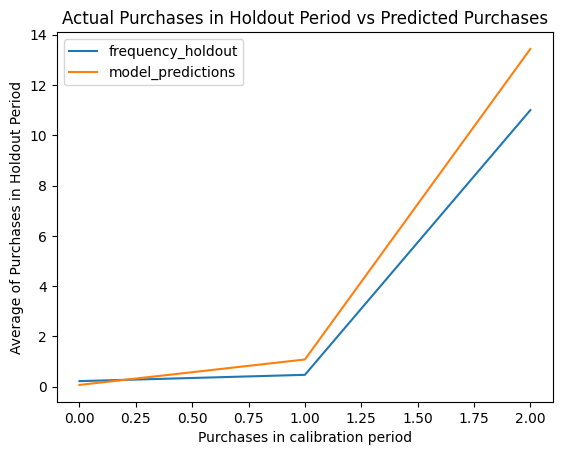

In [62]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

Tren model mirip dengan data aktual, meskipun prediksi sedikit lebih tinggi.

Artinya, model cukup bisa menangkap pola purchase behavior.

Ini validasi penting untuk CLTV / retention modeling.

#Customer transactions predictions

In [63]:
t = 30 #predict purchases in 10 periods
individual = cltv_ready.loc[1]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_, to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

np.float64(0.32194508729962257)

In [64]:
t = 10 #predict purchases in 10 periods
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_, to_time`
bgf.predict(t, cltv_ready['frequency'], cltv_ready['recency'], cltv_ready['T'])

customer_id
1         0.107351
598       0.001313
837       0.001508
839       0.000772
858       0.000191
994       0.008201
1023      0.001572
1039      0.000549
1099      0.000603
1224      0.000111
1229      0.000332
1232      0.000281
1234      0.000790
1259      0.000945
1386      0.000238
1439      0.000648
1553      0.001034
1569      0.001194
1580      0.000072
1612      0.000191
1625      0.000081
1637      0.000759
1663      0.000914
1785      0.003731
1815      0.008968
1841      0.000982
1846      0.000139
1874      0.000886
1900      0.012879
1918      0.000133
1927      0.000710
1930      0.000664
1933      0.011641
1947      0.000468
1949      0.004662
1962      0.001331
2033      0.000891
2036      0.011258
2038      0.000818
2048      0.000988
2051      0.000224
2053      0.000773
2074      0.000806
2083      0.000358
2122      0.001000
2129      0.000622
2139      0.000620
2141      0.004470
2161      0.000678
2171      0.000705
2178      0.000404
2191      0.002136
2196      0.000706
2207      0.003703
2261      0.001055
2262      0.000649
2275      0.000831
2290      0.000763
2295      0.000458
2298      0.007954
2329      0.000054
2369      0.000716
2379      0.000324
2382      0.000824
2402      0.008201
2412      0.000651
2420      0.000776
2429      0.000769
2431      0.000760
2482      0.000444
2484      0.000891
2495      0.000664
2504      0.001067
2515      0.001626
2528      0.000433
2536      0.000648
2548      0.000252
2567      0.000232
2608      0.000650
2628      0.013014
2635      0.000744
2640      0.000465
2642      0.000541
2646      0.000248
2654      0.014822
2663      0.000828
2680      0.011605
2684      0.000114
2688      0.000439
2693      0.000938
2704      0.011438
2711      0.000466
2723      0.012603
2730      0.014084
2744      0.000691
2759      0.000502
2764      0.000415
2767      0.009204
2806      0.006881
2809      0.000238
2813      0.000763
2815      0.000844
2821      0.000234
2822      0.008638
2854      0.011960
2879      0.000662
2889      0.001951
2929      0.000146
2938      0.000923
2942      0.006969
2950      0.000754
2967      0.000145
2979      0.000049
2980      0.000568
2992      0.000430
2997      0.000800
3003      0.000856
3005      0.001086
3006      0.019047
3019      0.000339
3029      0.000626
3035      0.000634
3039      0.001051
3054      0.000926
3055      0.013082
3062      0.000794
3063      0.000837
3082      0.000390
3088      0.000613
3095      0.000736
3096      0.000155
3098      0.000782
3107      0.000790
3116      0.000215
3122      0.002306
3128      0.001256
3130      0.010492
3135      0.000923
3138      0.009068
3150      0.000796
3155      0.000218
3166      0.000172
3169      0.001205
3171      0.007723
3179      0.000180
3181      0.000507
3187      0.000201
3188      0.001858
3195      0.000715
3200      0.011180
3225      0.000083
3239      0.000726
3244      0.000413
3251      0.000055
3259      0.011517
3262      0.002459
3264      0.001256
3287      0.000811
3292      0.009204
3303      0.000503
3314      0.001514
3320      0.000307
3322      0.010848
3330      0.000181
3339      0.000441
3345      0.000862
3353      0.000262
3354      0.000797
3362      0.009556
3367      0.000952
3372      0.000858
3386      0.000440
3391      0.000276
3393      0.004193
3420      0.000695
3423      0.000286
3434      0.013004
3442      0.000808
3454      0.000709
3457      0.014237
3460      0.008841
3463      0.000369
3483      0.001761
3495      0.001000
3511      0.001166
3531      0.007604
3533      0.000390
3542      0.000118
3548      0.000824
3552      0.000105
3558      0.000925
3565      0.002021
3579      0.000781
3588      0.000495
3589      0.000595
3595      0.000749
3597      0.000713
3602      0.000352
3615      0.000936
3627      0.001287
3631      0.012030
3634      0.000417
3643      0.008432
3648      0.000621
3664      0.000668
3666      0.001119
3674      0.000896
3685      0.001022
3687      0.008783
3696      0.00043

Our model predicts that customer 1's future transaction is 0.107351 in 10 days.

#Customer probability histories

In [65]:
t = 100
cltv_ready['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, cltv_ready['frequency'], cltv_ready['recency'], cltv_ready['T'])
best_projected_cust = cltv_ready.sort_values('predicted_purchases').tail(6)
cltv_ready.sort_values(by='predicted_purchases').tail(6)

frequency  recency       T  monetary_value  is_dormant  segment  \
customer_id                                                                    
87858              2.0    108.0   324.0     2400.500000       False   Active   
35063              2.0    132.0   335.0     4376.500000       False   Active   
100000             9.0   1734.0  1843.0     3154.444444        True  Dormant   
37975              2.0    192.0   308.0     2605.500000       False   Active   
68541              2.0    190.0   268.0     1385.500000       False   Active   
1                 24.0   2134.0  2165.0     3626.291667        True  Dormant   

             predicted_purchases  prob_alive  
customer_id                                   
87858                   0.375091    0.461086  
35063                   0.384747    0.470879  
100000                  0.465205    0.867138  
37975                   0.466731    0.527499  
68541                   0.536398    0.550896  
1                       1.071894    0.955307

Ini adalah pelanggan yang diprediksi akan melakukan pembelian terbanyak dalam t=100 waktu ke depan.
Misalnya:

Pelanggan ID=1 punya predicted_purchases = 1.07 ➜ diperkirakan akan melakukan ±1 pembelian ke depan, dengan prob_alive sangat tinggi (0.91).



In [66]:
cltv_ready.sort_values(by='prob_alive', ascending=True).tail(6)

frequency  recency       T  monetary_value  is_dormant  segment  \
customer_id                                                                    
13360              4.0   2025.0  2157.0     2362.500000        True  Dormant   
62716              4.0   1697.0  1783.0     2611.750000        True  Dormant   
66522              4.0   1694.0  1731.0     2959.250000        True  Dormant   
37770              4.0   2127.0  2166.0     3118.000000        True  Dormant   
100000             9.0   1734.0  1843.0     3154.444444        True  Dormant   
1                 24.0   2134.0  2165.0     3626.291667        True  Dormant   

             predicted_purchases  prob_alive  
customer_id                                   
13360                   0.175312    0.750194  
62716                   0.211102    0.762215  
66522                   0.217847    0.779251  
37770                   0.175456    0.780181  
100000                  0.465205    0.867138  
1                       1.071894    0.955307

Ini adalah pelanggan yang kemungkinan BESAR masih aktif, sehingga peluang untuk membeli lagi tinggi.

Contoh:

Pelanggan ID=1 muncul lagi ➜ prob_alive = 0.91 ➜ hampir pasti aktif.

Pelanggan lain ID=100000 juga punya prob_alive = 0.77.

predicted_purchases tinggi ➜ akan banyak beli.

prob_alive tinggi ➜ masih aktif, belum churn.

#Estimating customer lifetime value using gamma-gamma model of monetary value

In [67]:
summary = cltv_ready[cltv_ready['frequency']>0]
print(summary.head())
print()
print('\nCustomers with atleast 1 repeat purchase\n', len(summary))

             frequency  recency       T  monetary_value  is_dormant  segment  \
customer_id                                                                    
1                 24.0   2134.0  2165.0     3626.291667        True  Dormant   
598                1.0   1040.0  1202.0     3558.000000        True  Dormant   
837                1.0    530.0   817.0     4863.000000       False  Regular   
839                1.0    997.0  1585.0     2211.000000       False  Regular   
858                1.0     85.0  1219.0     3856.000000       False   Active   

             predicted_purchases  prob_alive  
customer_id                                   
1                       1.071894    0.955307  
598                     0.013067    0.220486  
837                     0.014978    0.181989  
839                     0.007697    0.145762  
858                     0.001905    0.052663  


Customers with atleast 1 repeat purchase
 6257


Artinya, dari semua pelanggan:
✅ 6257 pelanggan punya minimal 1 repeat purchase ➜ valid untuk dihitung nilai lifetime value-nya.



#The Gamma-Gamma model and the independence assumption

In [68]:
summary[['monetary_value', 'frequency']].corr()

monetary_value  frequency
monetary_value        1.000000  -0.006971
frequency            -0.006971   1.000000

orelasi antara monetary_value dan frequency = -0.006971
➜ Sangat mendekati 0, artinya tidak ada korelasi linear antara berapa sering orang belanja dan berapa besar rata-rata transaksi.

✅ Kenapa ini penting?
Ini prasyarat penting dalam Gamma-Gamma model:

Asumsi: Frekuensi pembelian TIDAK berkorelasi dengan rata-rata nilai pembelian.

Nilai -0.006971 ≈ 0 ➜ validasi bahwa kamu boleh menggunakan Gamma-Gamma untuk memperkirakan monetary value.

📌 Kesimpulan
✔️ Korelasi mendekati 0 ➜ Asumsi model terpenuhi
✔️ Gamma-Gamma dapat dipakai ➜ Prediksi CLTV kamu sahih.

Kalau mau, saya bisa bantu:

Visualisasikan scatter plot monetary_value vs frequency

Tunjukkan distribusi monetary value

Lanjutkan ke estimasi CLTV final

In [69]:
ggf = GammaGammaFitter(penalizer_coef = 0.001)
ggf.fit(summary['frequency'],
        summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 6257 subjects, p: 12.25, q: 0.35, v: 12.04>


In [70]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).tail(10))

customer_id
97970     1078.847051
98084     1807.197834
98121     3793.800985
98276     4733.267937
98404     3230.120813
98418     1035.568237
98745     1830.420613
98860     4824.047889
99267      864.564140
100000    3174.353827
dtype: float64


Customer 97970 diprediksi akan rata-rata belanja 1.078 per transaksi di masa depan.

In [71]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 3189.301664306418, Average profit: 3023.1962925967364


 Rata-rata prediksi profit per transaksi sedikit lebih tinggi daripada rata-rata historisnya.
Ini wajar — model mengoreksi ke mean.

In [72]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1       5484.686521
598      318.107206
837      396.137543
839      117.932796
858       92.790864
994      128.288824
1023     487.693135
1039     124.718697
1099     205.684327
1224      65.978930
Name: clv, dtype: float64


Customer ID 1 diprediksi akan memberikan ~5.484 revenue dalam 12 bulan ke depan (berdasarkan frekuensi belanja & nilai rata-rata).

#Saving model

In [73]:
bgf.save_model('bgf.pkl')

#Loading model

In [74]:
bgf_loaded = BetaGeoFitter()
bgf_loaded.load_model('bgf.pkl')
bgf_loaded

<lifetimes.BetaGeoFitter: fitted with 6257 subjects, a: 1.97, alpha: 3357.54, b: 0.68, r: 5.01>

In [75]:
bgf_loaded.conditional_expected_number_of_purchases_up_to_time(30, cltv_ready['frequency'], cltv_ready['recency'], cltv_ready['T'])

customer_id
1         0.142692
598       0.008505
837       0.007840
839       0.005017
858       0.002289
994       0.011549
1023      0.009512
1039      0.003294
1099      0.003933
1224      0.001339
1229      0.002463
1232      0.001578
1234      0.005790
1259      0.005556
1386      0.001356
1439      0.004867
1553      0.006256
1569      0.006666
1580      0.000893
1612      0.001052
1625      0.000835
1637      0.004610
1663      0.005471
1785      0.002724
1815      0.009556
1841      0.005780
1846      0.000864
1874      0.005951
1900      0.011897
1918      0.001088
1927      0.005751
1930      0.004045
1933      0.015796
1947      0.004218
1949      0.011818
1962      0.007054
2033      0.005357
2036      0.018566
2038      0.006127
2048      0.008500
2051      0.001561
2053      0.006447
2074      0.005085
2083      0.001921
2122      0.007709
2129      0.003803
2139      0.004033
2141      0.011964
2161      0.004869
2171      0.004502
2178      0.002394
2191      0.008971
2196      0.005775
2207      0.010925
2261      0.007884
2262      0.003946
2275      0.005389
2290      0.005763
2295      0.002639
2298      0.007062
2329      0.000766
2369      0.005780
2379      0.001756
2382      0.008067
2402      0.006156
2412      0.004730
2420      0.006845
2429      0.006747
2431      0.004630
2482      0.002682
2484      0.005521
2495      0.004036
2504      0.007773
2515      0.009991
2528      0.003184
2536      0.004522
2548      0.003250
2567      0.001762
2608      0.004075
2628      0.022369
2635      0.006137
2640      0.002688
2642      0.003299
2646      0.001639
2654      0.023209
2663      0.005774
2680      0.014180
2684      0.000966
2688      0.002694
2693      0.006035
2704      0.017779
2711      0.002748
2723      0.012822
2730      0.017360
2744      0.004417
2759      0.002967
2764      0.002444
2767      0.017292
2806      0.011993
2809      0.001455
2813      0.006472
2815      0.005943
2821      0.001319
2822      0.016724
2854      0.009960
2879      0.004423
2889      0.008843
2929      0.001100
2938      0.007032
2942      0.005152
2950      0.005433
2967      0.000873
2979      0.000902
2980      0.003575
2992      0.003694
2997      0.006031
3003      0.006696
3005      0.007125
3006      0.014477
3019      0.002136
3029      0.004512
3035      0.004093
3039      0.008218
3054      0.008076
3055      0.018144
3062      0.005504
3063      0.005182
3082      0.002146
3088      0.003764
3095      0.004469
3096      0.001241
3098      0.005091
3107      0.005424
3116      0.002847
3122      0.009757
3128      0.007102
3130      0.014980
3135      0.006009
3138      0.014930
3150      0.006285
3155      0.001256
3166      0.001525
3169      0.009099
3171      0.007182
3179      0.001134
3181      0.003059
3187      0.001809
3188      0.008541
3195      0.004580
3200      0.008468
3225      0.000734
3239      0.005373
3244      0.002809
3251      0.000650
3259      0.008642
3262      0.010205
3264      0.008422
3287      0.007679
3292      0.014453
3303      0.003034
3314      0.007799
3320      0.002277
3322      0.015026
3330      0.001423
3339      0.002641
3345      0.005747
3353      0.002196
3354      0.007333
3362      0.009343
3367      0.007731
3372      0.007608
3386      0.003044
3391      0.001735
3393      0.011415
3420      0.004895
3423      0.002085
3434      0.019018
3442      0.004912
3454      0.005174
3457      0.011393
3460      0.017371
3463      0.002678
3483      0.009577
3495      0.007714
3511      0.006731
3531      0.006844
3533      0.002525
3542      0.001475
3548      0.005057
3552      0.000822
3558      0.006410
3565      0.010119
3579      0.005287
3588      0.002908
3589      0.004189
3595      0.004643
3597      0.004708
3602      0.002831
3615      0.007109
3627      0.009279
3631      0.015672
3634      0.004795
3643      0.010961
3648      0.003981
3664      0.005155
3666      0.006962
3674      0.007929
3685      0.006204
3687      0.007663
3696      0.00305

#Eksploarasi lebih jauh

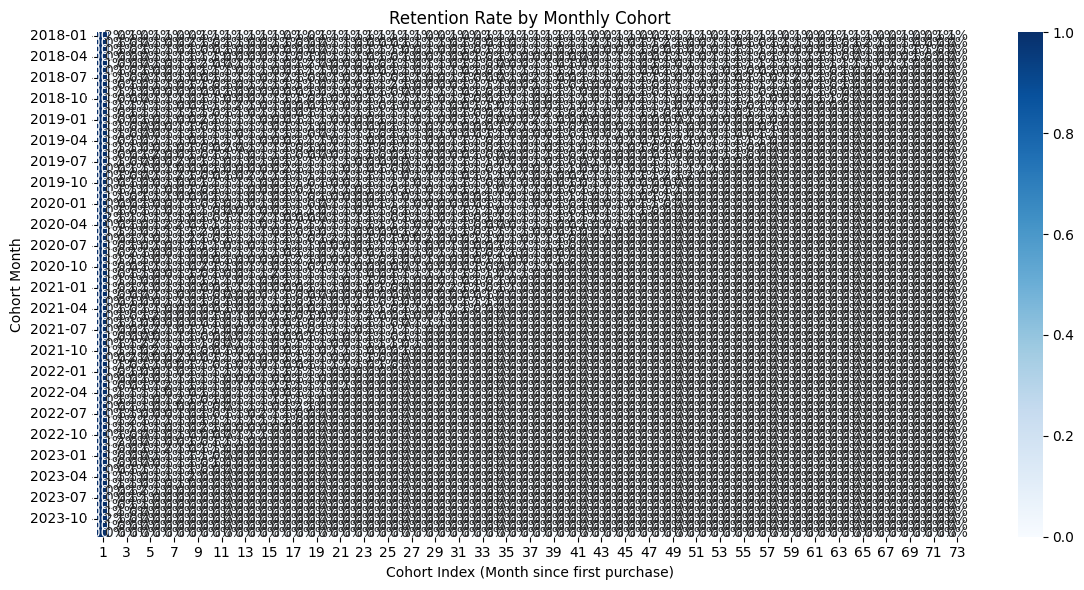

In [76]:
# 1. Pastikan kolom tanggal dalam format datetime
df['Purchase History'] = pd.to_datetime(df['Purchase History'])

# 2. Tambahkan kolom order_month (hanya bulan-tahun pembelian)
df['order_month'] = df['Purchase History'].dt.to_period('M')

# 3. Hitung cohort_month = bulan pertama customer beli
df['cohort_month'] = df.groupby('Customer ID')['order_month'].transform('min')

# 4. Hitung cohort_index = bulan ke-n dari pembelian pertama
df['cohort_index'] = (df['order_month'].dt.to_timestamp() - df['cohort_month'].dt.to_timestamp()) \
                        .apply(lambda x: x.days // 30 + 1)

# 5. Buat Retention Matrix: jumlah unique customer per cohort_index
retention = df.groupby(['cohort_month', 'cohort_index'])['Customer ID'] \
              .nunique().unstack(fill_value=0)

# 6. Hitung Retention Rate (dibagi jumlah customer bulan pertama)
cohort_sizes = retention.iloc[:, 0]
retention_rate = retention.divide(cohort_sizes, axis=0)

# 7. Visualisasi
plt.figure(figsize=(12, 6))
sns.heatmap(retention_rate, annot=True, fmt='.0%', cmap='Blues')
plt.title('Retention Rate by Monthly Cohort')
plt.xlabel('Cohort Index (Month since first purchase)')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

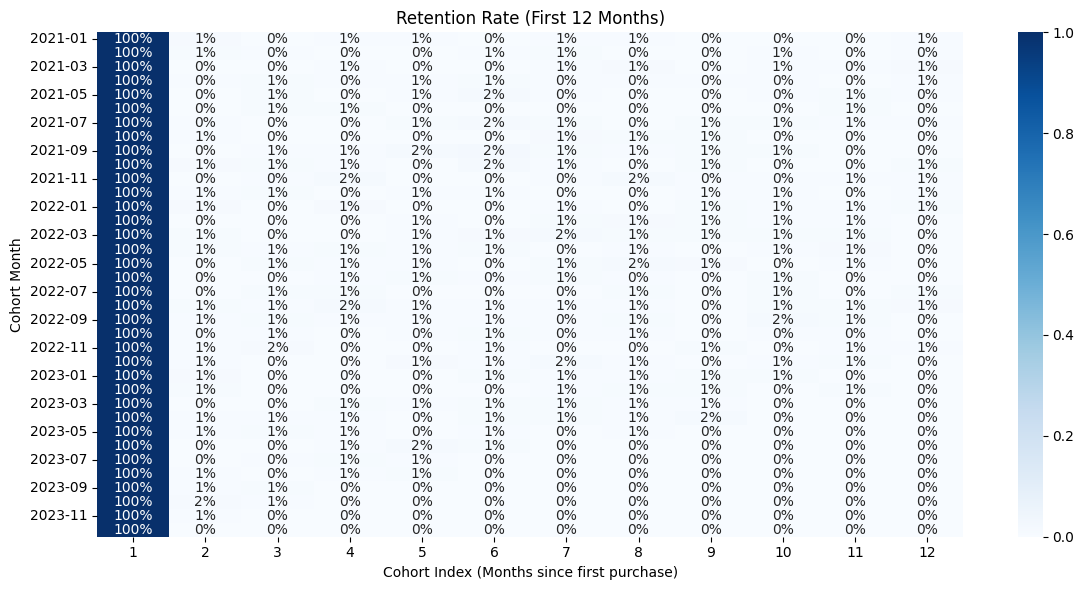

In [101]:
# Filter hanya 12 bulan pertama (cohort_index <= 12)
filtered_retention = retention_rate.loc[retention_rate.index >= '2021-01', :12]

# Plot ulang
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Retention Rate (First 12 Months)')
plt.xlabel('Cohort Index (Months since first purchase)')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()


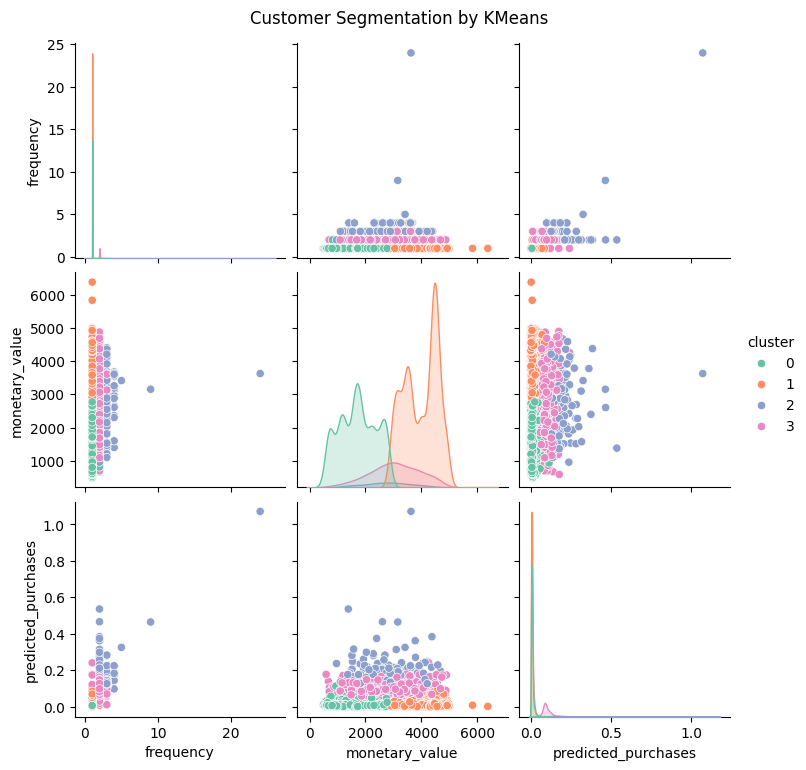

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih fitur
features = ['frequency', 'monetary_value', 'predicted_purchases']
X = summary[features]

# Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering dengan 4 segmen
kmeans = KMeans(n_clusters=4, random_state=42)
summary['cluster'] = kmeans.fit_predict(X_scaled)

# Visualisasi cluster
sns.pairplot(summary, hue='cluster', vars=features, palette='Set2')
plt.suptitle('Customer Segmentation by KMeans', y=1.02)
plt.show()


In [79]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6257 entries, 1 to 100000
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frequency            6257 non-null   float64
 1   recency              6257 non-null   float64
 2   T                    6257 non-null   float64
 3   monetary_value       6257 non-null   float64
 4   is_dormant           6257 non-null   bool   
 5   segment              6257 non-null   object 
 6   predicted_purchases  6257 non-null   float64
 7   prob_alive           6257 non-null   float64
 8   cluster              6257 non-null   int32  
dtypes: bool(1), float64(6), int32(1), object(1)
memory usage: 550.7+ KB


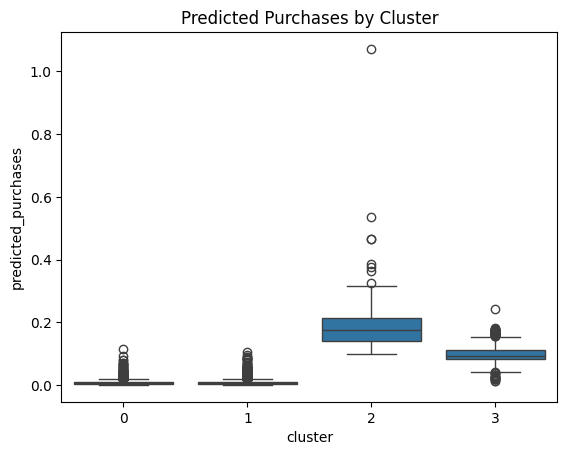

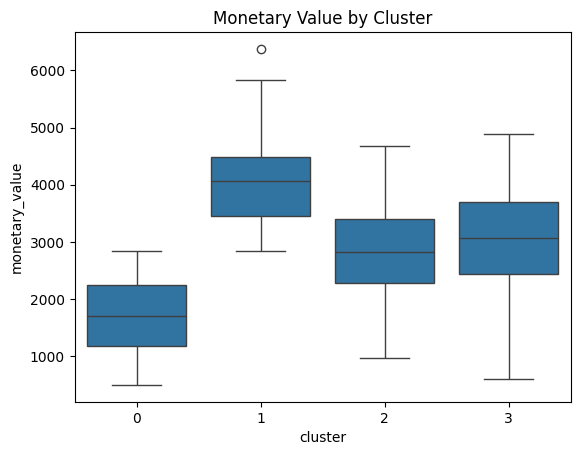

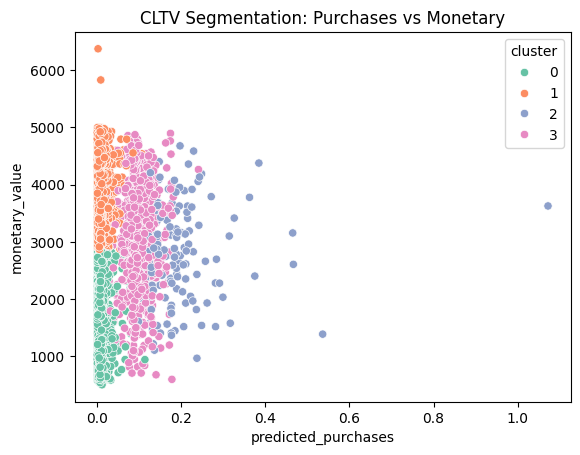

In [80]:
# Visualisasi distribusi cluster terhadap CLTV-related metrics
sns.boxplot(data=summary, x='cluster', y='predicted_purchases')
plt.title("Predicted Purchases by Cluster")
plt.show()

sns.boxplot(data=summary, x='cluster', y='monetary_value')
plt.title("Monetary Value by Cluster")
plt.show()

sns.scatterplot(data=summary, x='predicted_purchases', y='monetary_value', hue='cluster', palette='Set2')
plt.title("CLTV Segmentation: Purchases vs Monetary")
plt.show()


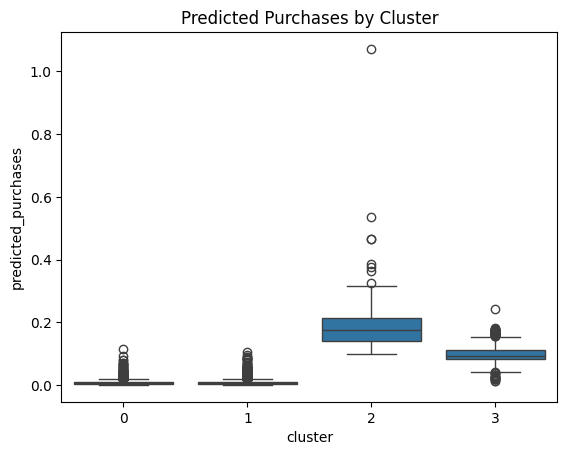

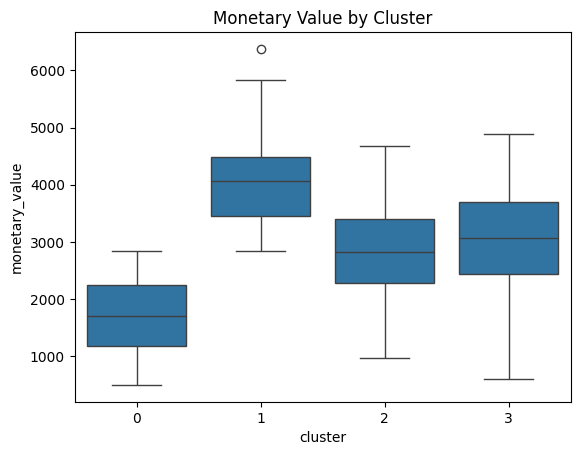

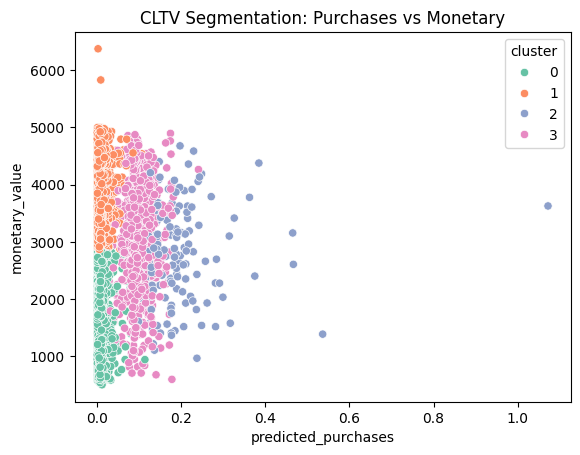

In [81]:
# Visualisasi distribusi cluster terhadap CLTV-related metrics
sns.boxplot(data=summary, x='cluster', y='predicted_purchases')
plt.title("Predicted Purchases by Cluster")
plt.show()

sns.boxplot(data=summary, x='cluster', y='monetary_value')
plt.title("Monetary Value by Cluster")
plt.show()

sns.scatterplot(data=summary, x='predicted_purchases', y='monetary_value', hue='cluster', palette='Set2')
plt.title("CLTV Segmentation: Purchases vs Monetary")
plt.show()


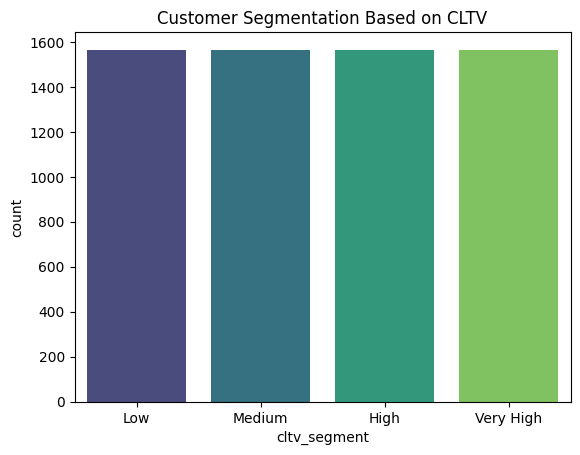

In [82]:
# Tambahkan CLTV ke summary
summary['CLTV'] = summary['predicted_purchases'] * summary['monetary_value']

# Segmentasi manual (misal kuantil)
summary['cltv_segment'] = pd.qcut(summary['CLTV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Visualisasi
sns.countplot(data=summary, x='cltv_segment', palette='viridis')
plt.title("Customer Segmentation Based on CLTV")
plt.show()


In [83]:
# Ambil fitur yang digunakan oleh BGNBD
features = ['frequency', 'recency', 'T']

# Standardisasi
X = summary[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
summary['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

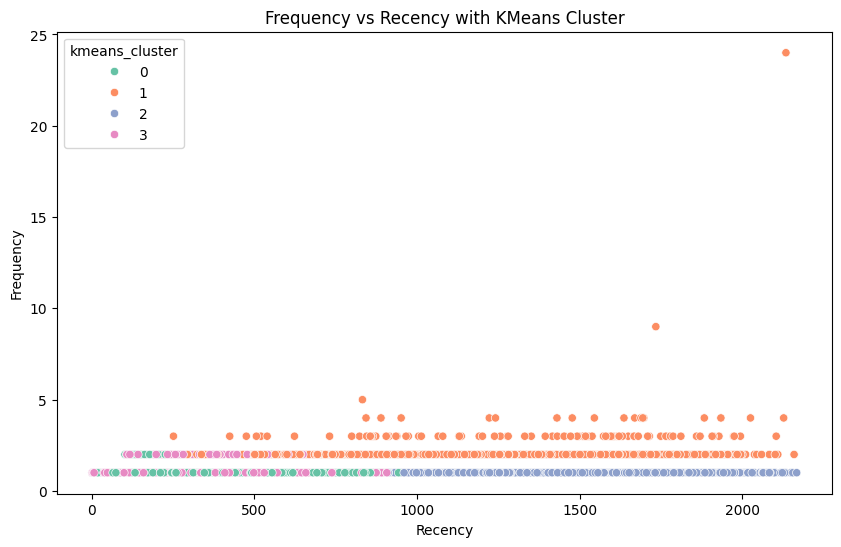

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary, x='recency', y='frequency', hue='kmeans_cluster', palette='Set2')
plt.title('Frequency vs Recency with KMeans Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

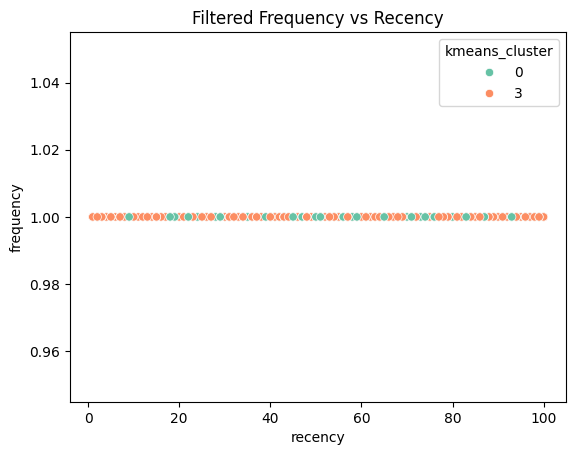

In [85]:
# Contoh: ambil pelanggan dengan frekuensi <= 10 & recency <= 100
filtered = summary[(summary['frequency'] <= 10) & (summary['recency'] <= 100)]

sns.scatterplot(data=filtered, x='recency', y='frequency', hue='kmeans_cluster', palette='Set2')
plt.title('Filtered Frequency vs Recency')
plt.show()


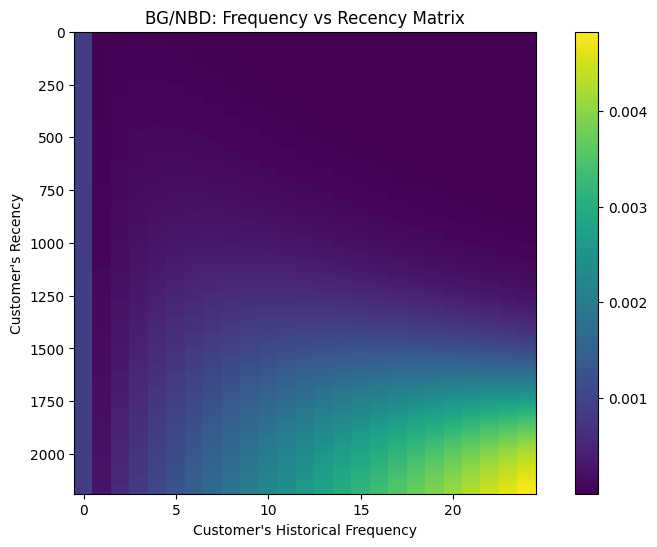

In [86]:
fig = plt.figure(figsize=(10, 6))
plot_frequency_recency_matrix(bgf)
plt.title('BG/NBD: Frequency vs Recency Matrix')
plt.show()

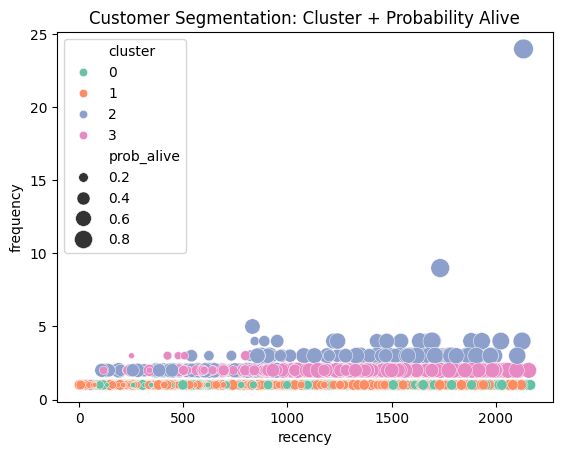

In [87]:
sns.scatterplot(
    data=summary,
    x='recency',
    y='frequency',
    hue='cluster',
    size='prob_alive',
    palette='Set2',
    sizes=(10, 200)
)
plt.title("Customer Segmentation: Cluster + Probability Alive")
plt.show()

In [88]:
summary.groupby('cluster')['prob_alive'].mean()

cluster
0    0.132454
1    0.132456
2    0.547841
3    0.397472
Name: prob_alive, dtype: float64

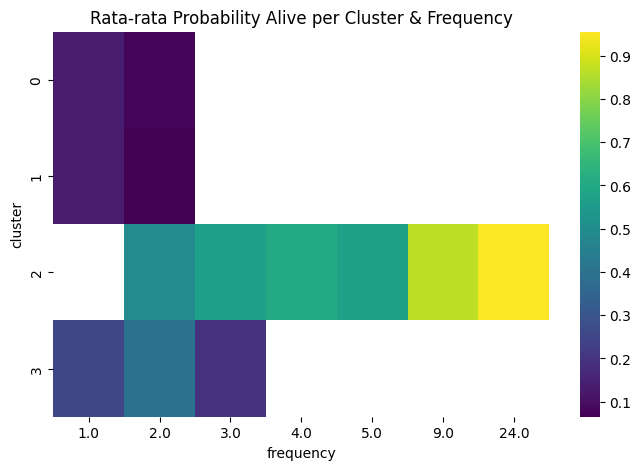

In [89]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    summary.pivot_table(values='prob_alive', index='cluster', columns='frequency'),
    cmap='viridis'
)
plt.title("Rata-rata Probability Alive per Cluster & Frequency")
plt.show()

In [90]:
summary.index.name

'customer_id'

In [91]:
summary = summary.reset_index()

In [92]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customer_id          6257 non-null   int64   
 1   frequency            6257 non-null   float64 
 2   recency              6257 non-null   float64 
 3   T                    6257 non-null   float64 
 4   monetary_value       6257 non-null   float64 
 5   is_dormant           6257 non-null   bool    
 6   segment              6257 non-null   object  
 7   predicted_purchases  6257 non-null   float64 
 8   prob_alive           6257 non-null   float64 
 9   cluster              6257 non-null   int32   
 10  CLTV                 6257 non-null   float64 
 11  cltv_segment         6257 non-null   category
 12  kmeans_cluster       6257 non-null   int32   
dtypes: bool(1), category(1), float64(7), int32(2), int64(1), object(1)
memory usage: 501.4+ KB


In [93]:
summary.head()

customer_id  frequency  recency       T  monetary_value  is_dormant  \
0            1       24.0   2134.0  2165.0     3626.291667        True   
1          598        1.0   1040.0  1202.0     3558.000000        True   
2          837        1.0    530.0   817.0     4863.000000       False   
3          839        1.0    997.0  1585.0     2211.000000       False   
4          858        1.0     85.0  1219.0     3856.000000       False   

   segment  predicted_purchases  prob_alive  cluster         CLTV  \
0  Dormant             1.071894    0.955307        2  3887.000224   
1  Dormant             0.013067    0.220486        1    46.494111   
2  Regular             0.014978    0.181989        1    72.835791   
3  Regular             0.007697    0.145762        0    17.017055   
4   Active             0.001905    0.052663        1     7.344029   

  cltv_segment  kmeans_cluster  
0    Very High               1  
1         High               2  
2    Very High               3  
3       Medium               2  
4          Low               3

In [94]:
summary.to_csv("summary.csv", index=False)

In [95]:
import json

# Simpan parameter bgf dan ggf
bgf_params = bgf.params_.to_dict()
ggf_params = ggf.params_.to_dict()

# Save ke file JSON
with open('bgf_params.json', 'w') as f:
    json.dump(bgf_params, f)

with open('ggf_params.json', 'w') as f:
    json.dump(ggf_params, f)


In [96]:
pip install joblib